# BIOINF 580 - Final Project

### Due Monday, Dec. 15 at 12:00pm (noon)


---

## Submission Requirement:  

- Submit the Jupyter notebook (`.ipynb`) file with all code and the written report included.  

- Name the file as: `Final_Project_YourUniqueName.ipynb`

---

## Final Project Overview

This final project consists of two independent tasks: 

- **Task 1 is a binary classification problem using ECG signals**, and 

- **Task 2 is a multi-class classification problem using dermatoscopic images**. 

This is an **individual project**, and no collaboration of any kind is allowed. **AI tools may be used**, but you must clearly state **which AI tools were used and how they contributed** to your work.


## Task 1: Healthy and Atrial Fibrillation ECG Signal Classification (50 points)

### **1.1 Task Goal**
The goal of this task is to build a binary classifier that distinguishes between **normal sinus rhythm (healthy)** and **atrial fibrillation (AFib)** from ECG signals.

### **1.2 Data Description**
You are provided with two datasets packaged in NumPy format:

- **`ecg_train_data.npz`**  
  Contains **3000 ECG samples**, each labeled as **0 = healthy** or **1 = AFib**.  
- **`ecg_valid_data.npz`**  
  Contains **500 ECG samples**, following the same format, provided for **validation**.  
- All ECG signals were sampled at **300 Hz**.

Each `.npz` file contains two arrays:
- `signals`: list/array of ECG recordings  
- `labels`: corresponding binary labels

### **1.3 Task Requirements**
- You may apply **any signal processing or preprocessing methods** you prefer.  
- You may extract **any features** you consider appropriate.
- You may use **any machine learning or deep learning classification model**.
- **Train your model on `ecg_train_data.npz`** and 
- **Evaluate your model on `ecg_valid_data.npz`**.
- Compute and report both the **AUROC** and the **F1-score** on the validation set.
- Your notebook must be **self-contained**, clean, and runnable top-to-bottom.

### **1.4 Grading (50 points total)**

#### **AUROC Component — 20 points**

Your highest AUROC achieved on the validation set will be converted into points using the following table:

| **AUROC Threshold** | **Score Formula (out of 20 pts)** | **Example Score** |
|---------------------|-----------------------------------|-------------------|
| **> 0.90**          | **100% × 20**                      | 20 pts            |
| **> 0.80**          | **90% × 20**                       | 18 pts            |
| **> 0.75**          | **85% × 20**                       | 17 pts            |
| **> 0.70**          | **80% × 20**                       | 16 pts            |
| **else**            | **75% × 20**                       | 15 pts            |
| **NaN or error**    | **0%**                             | 0 pts             |

#### **F1 Score Component — 20 points**

Your highest F1-score achieved on the validation set will be converted into points using the following table:

| **F1 Score Threshold** | **Score Formula (out of 20 pts)** | **Example Score** |
|------------------------|------------------------------------|-------------------|
| **> 0.80**             | **100% × 20**                       | 20 pts            |
| **> 0.75**             | **95% × 20**                        | 19 pts            |
| **> 0.40**             | **85% × 20**                        | 17 pts            |
| **> 0.30**             | **80% × 20**                        | 16 pts            |
| **else**               | **75% × 20**                        | 15 pts            |
| **NaN or error**       | **0%**                              | 0 pts             |

#### **Report Component — 10 points**

Your written report must:
- **explicitly report the highest AUROC and highest F1-score achieved** on the validation set,
- describe the **challenges** you faced,  
- state **which AI tools** (if any) were used, and explain **how those AI tools contributed**.

  

In [21]:
### Starter Code: Loading and Inspecting the Datasets

import numpy as np

# Load training data
train = np.load("ecg_train_data.npz", allow_pickle=True)
X_train = train["signals"]
y_train = train["labels"]

# Load validation data
valid = np.load("ecg_valid_data.npz", allow_pickle=True)
X_valid = valid["signals"]
y_valid = valid["labels"]

print("Training samples:", len(X_train))
print("Validation samples:", len(X_valid))

# Inspect first sample
print("First signal length:", len(X_train[0]))
print("First 10 values of first signal:", X_train[0][:10])
print("First label:", y_train[0])


Training samples: 3000
Validation samples: 500
First signal length: 9000
First 10 values of first signal: [-0.281 -0.338 -0.4   -0.466 -0.523 -0.545 -0.553 -0.555 -0.555 -0.555]
First label: 0


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve
import random

# Reproducibility

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Helper functions

# Clean up data
def standardize_heartbeat_length(signals, target_len=None):
    if target_len is None:
        target_len = max(len(s) for s in signals)
    
    padded = np.zeros((len(signals), target_len), dtype=np.float32)
    for i, sig in enumerate(signals):
        sig = np.nan_to_num(sig)
        length = min(len(sig), target_len)
        padded[i, :length] = sig[:length]
    return padded, target_len

# Convert to tensor and prepare data for Dataloader
class ECGPatients(Dataset):
    def __init__(self, signals, labels):
        self.signals = torch.tensor(signals, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

    def __len__(self): return len(self.signals)
    def __getitem__(self, idx): return self.signals[idx], self.labels[idx]

# Train one epoch function
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        loss = criterion(model(inputs), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        running_loss += loss.item()
        
    # Return average loss for this epoch
    return running_loss / len(loader)

#Function to evaluate model after training
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad(): 
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            loss = criterion(model(inputs), targets)
            running_loss += loss.item()
            
    #Return average loss for this evaluation      
    return running_loss / len(loader)
    
# Design model, CNN with transformer

class AFibDetector(nn.Module):
    def __init__(self):
        super(AFibDetector, self).__init__()
        
        # CNN Model to extract features
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, 15, stride=2, padding=7), nn.BatchNorm1d(32), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 15, stride=2, padding=7), nn.BatchNorm1d(64), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 15, stride=2, padding=7), nn.BatchNorm1d(128), nn.ReLU(), nn.MaxPool1d(2),
        )
        
        # Transformer 
        self.pos_embedding = nn.Parameter(torch.randn(1, 500, 128))
        encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=4, dim_feedforward=256, dropout=0.4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        # Classifier
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.4), nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0, 2, 1) # [Batch, Time, Channels]
        x = x + self.pos_embedding[:, :x.size(1), :]
        x = self.transformer(x)
        x = x.permute(0, 2, 1) # [Batch, Channels, Time]
        x = self.global_pool(x).squeeze(-1)
        return self.fc(x)

# Run the model

# Load data
print("Loading data...")
train_data = np.load('ecg_train_data.npz', allow_pickle=True)
valid_data = np.load('ecg_valid_data.npz', allow_pickle=True)
X_train, y_train = train_data['signals'], train_data['labels']
X_valid, y_valid = valid_data['signals'], valid_data['labels']

# Preprocess
X_train_pad, max_len = standardize_heartbeat_length(X_train)
X_valid_pad, _ = standardize_heartbeat_length(X_valid, target_len=max_len)

# Scale data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train_pad)
X_valid_norm = scaler.transform(X_valid_pad)

# Loaders
train_loader = DataLoader(ECGPatients(X_train_norm, y_train), batch_size=32, shuffle=True)
valid_loader = DataLoader(ECGPatients(X_valid_norm, y_valid), batch_size=32, shuffle=False)
# Loader for threshold optimization (sequential training data)
train_seq_loader = DataLoader(ECGPatients(X_train_norm, y_train), batch_size=32, shuffle=False)

# Initiate model
model = AFibDetector().to(device)

# Apply custom weights 
num_pos = np.sum(y_train == 1)
num_neg = np.sum(y_train == 0)
pos_weight = torch.tensor([(num_neg / num_pos) * 1.5], device=device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

# Save loss and state of best model
best_loss = float('inf')
best_model_state = None

print("Training...")

# Run through epochs
for epoch in range(12): 
    #Train the model
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Validation check
    valid_loss = evaluate(model, valid_loader, criterion, device)
    
    # Save best model
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_model_state = model.state_dict()
        print(f"Epoch {epoch+1}: New Best Loss: {valid_loss:.4f}")
    else:
        print(f"Epoch {epoch+1}: Loss: {valid_loss:.4f}")

# Load best model for final evaluation
print("Loading best model...")
model.load_state_dict(best_model_state)
model.eval()

# Generate training probabilities for threshold optimization
y_train_probs = []
with torch.no_grad():
    for inputs, _ in train_seq_loader:
        y_train_probs.extend(torch.sigmoid(model(inputs.to(device))).cpu().numpy())

y_train_probs = np.array(y_train_probs).flatten()

# Optimize Threshold on training data
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Optimal Threshold: {best_threshold:.4f}")

# Final Predictions on validation data
y_probs = []
with torch.no_grad():
    for inputs, _ in valid_loader:
        y_probs.extend(torch.sigmoid(model(inputs.to(device))).cpu().numpy())

y_probs = np.array(y_probs).flatten()
y_pred = (y_probs >= best_threshold).astype(int)

print("-" * 30)
print(f"Validation AUROC: {roc_auc_score(y_valid, y_probs):.4f}")
print(f"Validation F1 Score: {f1_score(y_valid, y_pred):.4f}")
print("-" * 30)

Using device: cuda
Loading data...
Training...
Epoch 1: New Best Loss: 1.3352
Epoch 2: New Best Loss: 1.0576
Epoch 3: New Best Loss: 0.8483
Epoch 4: New Best Loss: 0.7331
Epoch 5: New Best Loss: 0.6487
Epoch 6: New Best Loss: 0.5580
Epoch 7: Loss: 0.5783
Epoch 8: New Best Loss: 0.5087
Epoch 9: Loss: 0.6409
Epoch 10: Loss: 0.6616
Epoch 11: Loss: 0.7356
Epoch 12: Loss: 0.7655
Loading best model...
Optimal Threshold: 0.8274
------------------------------
Validation AUROC: 0.9748
Validation F1 Score: 0.8175
------------------------------


**Performance Report**:
In this project, I elected to implement a hybrid CNN-Transformer architecture trained over 12 epochs, which successfully distinguished atrial fibrillation from normal rhythm based on ECG data. In order to prevent data leakage, the optimal classification threshold was determined based on the precision-recall curve of the training dataset, leaving the test dataset for the final evaluation. Specifically, the model achieved a final AUROC of 0.9748 and F1 score of 0.8175 on the validation dataset.

**Challenges**: 
A key issue I faced when designing the model was the significant amount of noise and variation in the ECG data, which would be inefficient to directly load into a transformer. Accordingly, I decided to first use a CNN as a feature extractor to better identify important physiological signals like the QRS complexes. Furthermore, another challenge was the CNN alone lacked the context to understand the order of signals in the ECG data. To improve this, I introduced a transformer paired with positional encodings to better describe the sequence of heartbeats. The combination of CNN and transformer dramatically increased the evaluation F1 score, which helps demonstrate its clinical viability for providing both an accurate and reliable diagnosis. 
In addition to the architectural challenges, I also encountered difficulties with the setup of the dataset. Specifically, the number of healthy cases in the provided dataset far outnumbered those with AFib, meaning I had to ensure the model would not simply learn to diagnose a patient as healthy to score a high accuracy. Therefore, I weighted the loss function with a penalty against missing AFib, which helped increase the model’s reliability. 
Finally, a third challenge was ensuring there was no data leakage between the training and test datasets, meaning I wanted to avoid the model overfitting on test data and not learning to recognize features. This was resolved by importing the training and test datasets separately and ensuring the test set was not implemented prior to the final evaluation. This should enhance the model’s ability to generalize to unseen patients. 

**AI Tools Statement**:
Gemini was used in this portion of the assignment to help describe the syntax/architecture of transformers, assist in restructuring code blocks into functions, and aid in debugging steps, such as identifying missing seeds to enhance reproducibility. 


## Task 2: Dermatoscopic Image Multi-Class Classification (50 points)

### **2.1 Task Goal**
The goal of this task is to build a **multi-class classifier** that identifies the type of skin lesion from dermatoscopic images.

### **2.2 Data Description**

In this task, you will use the **DermaMNIST** dataset from **medMNIST**, a curated collection of dermatoscopic images designed for lightweight benchmarking of medical image classification tasks.

- The dataset contains images from **7 diagnostic categories** of skin lesions.  
- Each image is provided at a standardized resolution of **64 × 64 pixels** when loaded with `size=64` (as in the starter code).  
- The **training set** contains **7,007 images**.  
- The **test set** contains **2,005 images**.

Each sample consists of:
- an **RGB dermatoscopic image** of shape $(64 \times 64 \times 3)$,  
- a **label** in the set \{0,1,2,3,4,5,6\}, where each integer corresponds to one of the seven lesion classes.

You may inspect a subset of the dataset using the provided starter code, which downloads the data and visualizes sample images.

### **2.3 Task Requirements**

- You may use **any convolutional neural network (CNN) classifier** architecture.  
- Train your CNN classifier using the **train** dataset.  
- Evaluate your model using the **test** dataset.  
- Compute and report the **One-vs-Rest (OvR) AUC** for all **7 classes**, and your final performance score will be based on the **mean OvR AUC across all classes**.
- Your notebook must be **self-contained**, clean, and runnable top-to-bottom.

### **2.4 Grading (50 points total)**

#### **Mean OvR AUC Component — 40 points**

Your highest mean OvR AUC across the 7 classes on the test dataset will be mapped to points using the following table:

| **Mean OvR AUC Threshold** | **Score Formula (out of 40 pts)** | **Example Score** |
|----------------------------|------------------------------------|-------------------|
| **> 0.90**                 | **100% × 40**                      | 40 pts            |
| **> 0.80**                 | **90% × 40**                       | 36 pts            |
| **> 0.75**                 | **85% × 40**                       | 34 pts            |
| **> 0.70**                 | **80% × 40**                       | 32 pts            |
| **else**                   | **75% × 40**                       | 30 pts            |
| **NaN or error**           | **0%**                             | 0 pts             |

#### **Report Component — 10 points**

Your written report must:
- **explicitly report the highest mean OvR AUC achieved** on the test dataset.
- clearly describe the **challenges** you faced,  
- state **which AI tools** (if any) were used, and explain **how those AI tools contributed**.


100%|███████████████████████████████████████████████████████████████████████████████| 100M/100M [00:07<00:00, 13.7MB/s]


Using downloaded and verified file: C:\Users\jawin\.medmnist\dermamnist_64.npz


C:\Users\jawin\AppData\Local\Temp\ipykernel_5200\1209921531.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)   # convert array([3]) -> 3


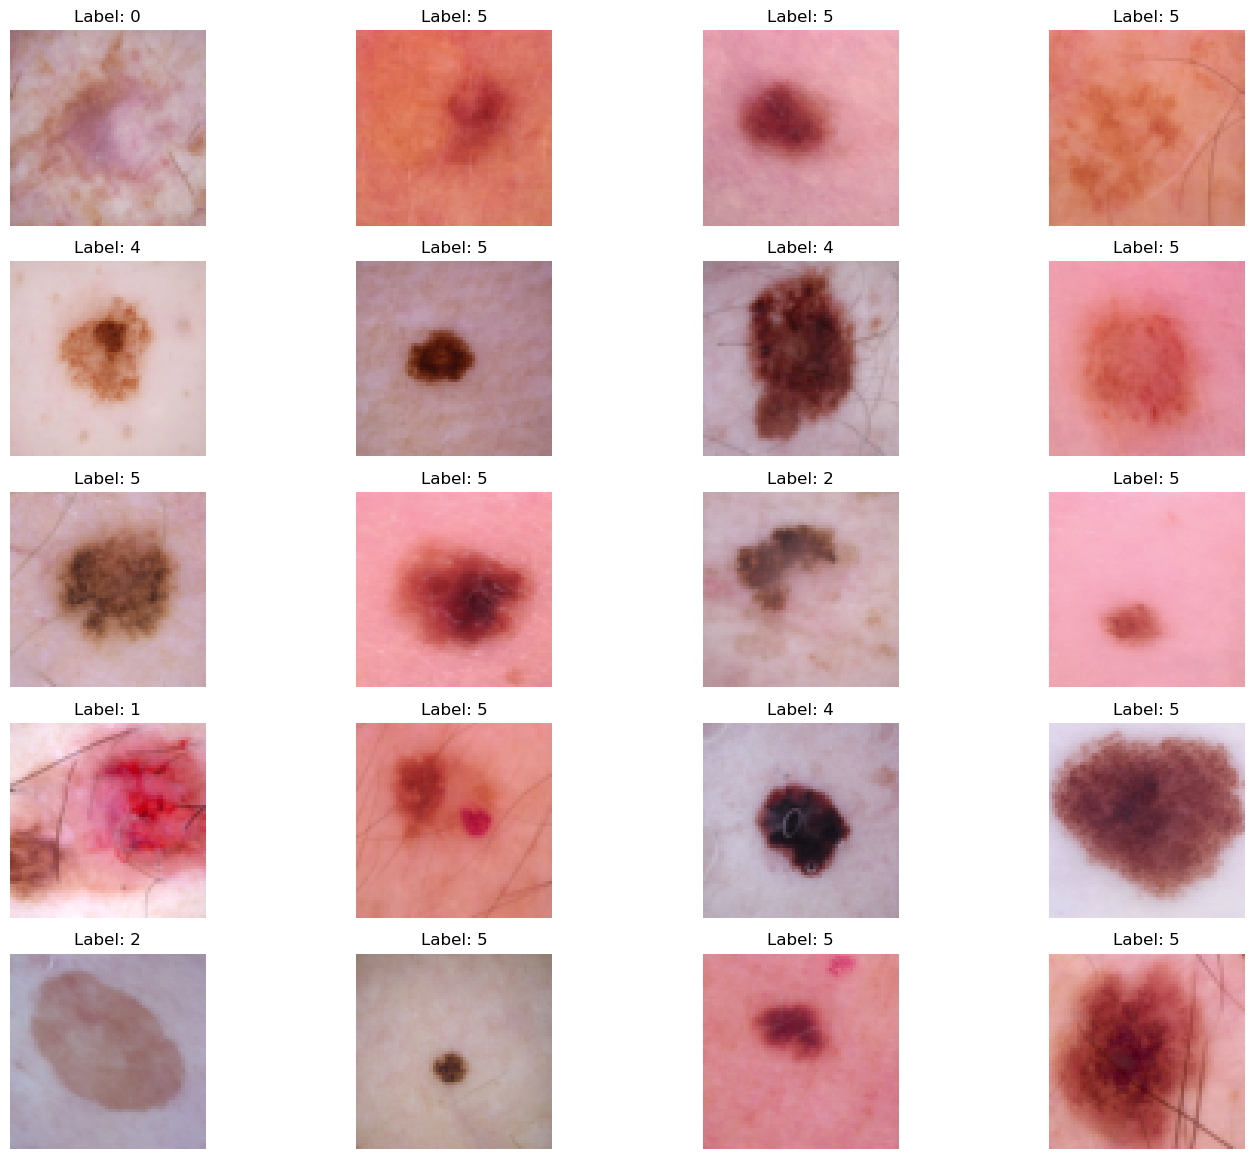

In [2]:
### Starter Code: Loading the Dataset (with labels)

from medmnist import DermaMNIST
import matplotlib.pyplot as plt

# Load DermaMNIST dataset
train = DermaMNIST(split="train", download=True, size=64)
test = DermaMNIST(split="test", download=True, size=64)

# DermaMNIST returns tuples of (image, label)
# image:  (64, 64, 3)
# label:  array([class_index], dtype=int)

def show_images_with_labels(dataset, num_samples=20, cols=4):
    """ Plots sample images along with their labels """
    plt.figure(figsize=(14, 14))
    
    for i in range(num_samples):
        img, label = dataset[i]
        label = int(label)   # convert array([3]) -> 3
        
        plt.subplot((num_samples // cols) + 1, cols, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Display sample training images with labels
show_images_with_labels(train)


In [6]:
# Import packages
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from medmnist import DermaMNIST
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import copy 

# Set seeds for reproducibility 
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)            
torch.cuda.manual_seed_all(0)    
torch.backends.cudnn.deterministic = True 
torch.backends.cudnn.benchmark = False    

# Set device to cuda if available 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load datasets
print("Loading DermaMNIST...")
train_data = DermaMNIST(split='train', download=True, size=64)
test_data  = DermaMNIST(split='test', download=True, size=64)

X_train_raw = train_data.imgs
y_train_raw = train_data.labels
X_test_raw  = test_data.imgs
y_test_raw  = test_data.labels


# Preprocess data
def preprocess_data(X_np, y_np):
    # Convert to Tensor
    X_tensor = torch.tensor(X_np, dtype=torch.float32)
    
    # Convert dimensions to RGB
    X_tensor = X_tensor.permute(0, 3, 1, 2)
    
    # Scale pixel values to [0, 1]
    X_tensor = X_tensor / 255.0
    
    # Flatten labels and convert to long for multi-class targets
    y_tensor = torch.tensor(y_np, dtype=torch.long).squeeze()
    
    return X_tensor, y_tensor

X_train_t, y_train_t = preprocess_data(X_train_raw, y_train_raw)
X_test_t,  y_test_t  = preprocess_data(X_test_raw,  y_test_raw)

# Calculate class weights
class_counts = torch.bincount(y_train_t)
total_samples = len(y_train_t)
num_classes = 7
class_weights = total_samples / (num_classes * class_counts.float())
class_weights = class_weights.to(device)

print(f"Class Weights: {class_weights.cpu().numpy()}")

# Create TensorDatasets
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

# Create Test Loader 
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

# Class to create CNN 
class MedMNISTCNN(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        
        # Block 1: 64x64 -> 32x32
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Block 2: 32x32 -> 16x16
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Block 3: 16x16 -> 8x8
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Classifier 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8192, hidden_dim), 
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, 7)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.classifier(x)
        return x 

# Helper Functions

# Train epochs
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

# Evaluate metrics 
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)
            probs = F.softmax(logits, dim=1)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(yb.cpu().numpy())
            
    avg_loss = total_loss / len(loader.dataset)
    
    if len(all_probs) > 0:
        all_probs = np.concatenate(all_probs)
        all_labels = np.concatenate(all_labels)
        
        try:
            auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
            preds = np.argmax(all_probs, axis=1)
            acc = accuracy_score(all_labels, preds)
        except ValueError:
            auc, acc = 0.0, 0.0
    else:
        auc, acc = 0.0, 0.0
        
    return avg_loss, auc, acc

# Stratified K-fold with hyperparameter tuning

# Define Parameters
param_grid = [
    {"batch_size": 32, "hidden_dim": 128},
    {"batch_size": 32, "hidden_dim": 256},
    {"batch_size": 64, "hidden_dim": 128},
    {"batch_size": 64, "hidden_dim": 256}
]

# Initialize set values for parameter tuning / cross-validation
num_epochs_cv = 5 
n_splits = 5            
lr = 1e-3                
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_results = []
y_train_np = y_train_t.numpy()

print("Starting Tuning with K-Fold CV...")

# Loop through hyperparameter values
for config in param_grid:
    print(f"\n=== Config: batch_size={config['batch_size']}, hidden_dim={config['hidden_dim']} ===")
    fold_aucs = []

    # Subset the data into batches
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(y_train_np)), y_train_np)):
        train_subset = Subset(train_ds, train_idx)
        val_subset   = Subset(train_ds, val_idx)
        train_loader = DataLoader(train_subset, batch_size=config["batch_size"], shuffle=True)
        val_loader   = DataLoader(val_subset,   batch_size=config["batch_size"], shuffle=False)
        
        # Pass hidden_dim to the model
        model = MedMNISTCNN(hidden_dim=config["hidden_dim"]).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights) 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

        #Train epochs and report AUC
        for epoch in range(1, num_epochs_cv + 1):
            train_one_epoch(model, train_loader, criterion, optimizer, device)
            
        _, final_auc, _ = evaluate(model, val_loader, criterion, device)
        fold_aucs.append(final_auc)
        print(f"  Fold {fold_idx + 1}/{n_splits} -> OvR AUC: {final_auc:.4f}")

    # Calculate and report mean AUC of folds
    mean_auc = np.mean(fold_aucs)
    std_auc = np.std(fold_aucs)
    cv_results.append({
        "config": config,
        "mean_auc": mean_auc,
        "std_auc": std_auc
    })
    print(f"Mean OvR AUC : {mean_auc:.4f} (+/- {std_auc:.4f})")

# Select best hyperparameters based on highest mean AUC
best_idx = np.argmax([res["mean_auc"] for res in cv_results])
best_config = cv_results[best_idx]["config"]

print("\n==============================")
print(f"Best config: batch_size={best_config['batch_size']}, hidden_dim={best_config['hidden_dim']}")
print("==============================\n")

# Final model training

# Load the best model found during hyperparameter tuning/cross-validation steps
best_model = MedMNISTCNN(hidden_dim=best_config["hidden_dim"]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(best_model.parameters(), lr=lr, weight_decay=1e-4)
train_loader = DataLoader(train_ds, batch_size=best_config["batch_size"], shuffle=True)

# Initialize set variables for early stopping epoch function
# High initial epochs will be stopped early with stopping function
num_epochs_final = 100
patience = 10  
counter = 0          
best_val_auc = 0.0    
best_model_wts = copy.deepcopy(best_model.state_dict())

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=5, verbose=True
)

print(f"===== Final Training (Max {num_epochs_final} epochs) =====")

# Run through epochs
for epoch in range(1, num_epochs_final + 1):
    #Train model
    train_loss = train_one_epoch(best_model, train_loader, criterion, optimizer, device)
    
    # Record loss, AUC, accuracy
    val_loss, val_auc, val_acc = evaluate(best_model, test_loader, criterion, device)
    
    # Run the scheduler function
    scheduler.step(val_auc) 
    
    print(f"Epoch {epoch:03d}: Train Loss={train_loss:.4f} | Val AUC={val_auc:.4f} | Val Acc={val_acc:.4f}")

    # Prevents epoch function from continuing if plateau is reached
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model_wts = copy.deepcopy(best_model.state_dict())
        counter = 0 
    else:
        counter += 1
        if counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}!")
            break

print(f"\nRestoring best model weights with Val AUC: {best_val_auc:.4f}")
best_model.load_state_dict(best_model_wts)

# Final Evaluation
_, final_auc, final_acc = evaluate(best_model, test_loader, criterion, device)

print("\n===== Final Test Performance =====")
print(f"Mean OvR AUC : {final_auc:.4f}")
print(f"Accuracy     : {final_acc:.4f}")



Using device: cuda
Loading DermaMNIST...
Using downloaded and verified file: C:\Users\jawin\.medmnist\dermamnist_64.npz
Using downloaded and verified file: C:\Users\jawin\.medmnist\dermamnist_64.npz
Class Weights: [ 4.390351   2.788301   1.3016905 12.5125     1.2849807  0.2132964
 10.111111 ]
Starting Tuning with K-Fold CV...

=== Config: batch_size=32, hidden_dim=128 ===
  Fold 1/5 -> OvR AUC: 0.8530
  Fold 2/5 -> OvR AUC: 0.8595
  Fold 3/5 -> OvR AUC: 0.8155
  Fold 4/5 -> OvR AUC: 0.8302
  Fold 5/5 -> OvR AUC: 0.8280
Mean OvR AUC : 0.8372 (+/- 0.0164)

=== Config: batch_size=32, hidden_dim=256 ===
  Fold 1/5 -> OvR AUC: 0.8272
  Fold 2/5 -> OvR AUC: 0.8477
  Fold 3/5 -> OvR AUC: 0.8562
  Fold 4/5 -> OvR AUC: 0.8766
  Fold 5/5 -> OvR AUC: 0.8291
Mean OvR AUC : 0.8474 (+/- 0.0183)

=== Config: batch_size=64, hidden_dim=128 ===
  Fold 1/5 -> OvR AUC: 0.8372
  Fold 2/5 -> OvR AUC: 0.8350
  Fold 3/5 -> OvR AUC: 0.8642
  Fold 4/5 -> OvR AUC: 0.8694
  Fold 5/5 -> OvR AUC: 0.8455
Mean OvR AU

C:\Users\jawin\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001: Train Loss=1.9397 | Val AUC=0.8009 | Val Acc=0.4165
Epoch 002: Train Loss=1.7124 | Val AUC=0.8333 | Val Acc=0.5272
Epoch 003: Train Loss=1.6350 | Val AUC=0.8056 | Val Acc=0.4145
Epoch 004: Train Loss=1.5603 | Val AUC=0.8422 | Val Acc=0.5397
Epoch 005: Train Loss=1.5163 | Val AUC=0.8643 | Val Acc=0.5401
Epoch 006: Train Loss=1.5215 | Val AUC=0.8360 | Val Acc=0.4589
Epoch 007: Train Loss=1.5210 | Val AUC=0.8680 | Val Acc=0.5257
Epoch 008: Train Loss=1.4668 | Val AUC=0.8574 | Val Acc=0.5067
Epoch 009: Train Loss=1.4219 | Val AUC=0.8747 | Val Acc=0.5441
Epoch 010: Train Loss=1.4803 | Val AUC=0.8773 | Val Acc=0.4873
Epoch 011: Train Loss=1.4321 | Val AUC=0.8606 | Val Acc=0.5077
Epoch 012: Train Loss=1.3896 | Val AUC=0.8779 | Val Acc=0.5431
Epoch 013: Train Loss=1.3645 | Val AUC=0.8741 | Val Acc=0.5197
Epoch 014: Train Loss=1.3312 | Val AUC=0.8777 | Val Acc=0.5397
Epoch 015: Train Loss=1.3196 | Val AUC=0.8809 | Val Acc=0.5601
Epoch 016: Train Loss=1.3192 | Val AUC=0.8607 | Val Acc

**Performance Report**: In this project, I implemented a custom 3-block CNN architecture, which successfully distinguished between seven different types of skin lesions using dermatoscopic images. A maximum of 100 training epochs were allotted, with an early stopping function included to prevent more training when loss and AUC leveled out. The final run trained on 62 epochs. Hyperparameter tuning and cross-fold validation were also utilized to ensure the optimal parameters were accessed by the final training model. The model achieved a final OvR AUC of 0.9088 on the test dataset.

**Challenges**: The major issue I faced was adapting the CNN to handle increased complexity of the skin lesion images compared to the previous grayscale pneumonia dataset. The images were both larger and in color, which increased the computational load and required a different method of loading into the model. Futhermore, I also encountered difficulties with an uneven distribution of images within each of the seven different classes. Accordingly, I weighted the loss function to penalize the model more heavily for misidentifying rarer classifications. This resulted in a model with moderate raw accuracy but a high OvR AUC, indicating it effectively ranks the correct classification higher even if it lacks perfect confidence. Finally, a third challenge was getting the model to correctly distinguish between the small differences in visually similar skin lesion images. This meant the model was prone to overfitting to the images themselves, rather than specific features that distinguish the seven subtypes from each other. I addressed this by carefully tuning the dropout rate in the classifier and utilizing the ReduceLROnPlateau scheduler to refine the weights only when improvements in generalization were detected.

**AI Tools Statement**: Gemini was used in this section to help adapt the preprocessing pipeline for RGB tensor shapes, explain the discrepancy between accuracy and OvR AUC metrics and for debugging the early stopping function with epoch count selection.